## Detecção de obstrução em válvulas de máquinas de LC por análise de séries temporais
### IFES - PPCOMP - Mestrado em Computação Aplicada

**Notebook**: Seleção de características e Clusterização v0.4

Periodo preliminar de análise: 01/2019 e 02/2019 (2 meses)
*****
**Datasets** (40+ Séries Temporais em intervalos de 10/10 segundos)

**Fonte:** Notebook - featureExtraction-clogging
+ features_Strand4.csv (Caracteristicas extraidas - Veio 4)
*****

Este Notebook busca identificar situações anômalas no comportamento de sinais temporais que foram discretizado em um conjunto de caracteristicas por intermedio de janela deslizante.

A abordagem a ser utilizada para identificação será o uso de uma técnica de aprendizado de máquina não supervisionada, neste caso agrupamento (clustering). 

A proposição foi de realizar uma clusterização multidimensional seguindo as seguintes etapas:
+ Seleção de caracterísitcas: Eliminação de variância '0' e correlação superior a 0.98 entre as dimensões.
+ Limpeza de valores NaN/Inf
+ Normalização dos dados (*StandardScaler*)
+ Clusterização utilizando o metodo DBSCAN *(Density Based Spatial Clustering of Applications with Noise)*
+ Alteração do espaço dimensional para visualização dos resultados (TSNE e UMAP)
+ Separação dos outliers (cluster label = -1) e realização de nova clusterização no espaço spectral
+ Identificação das regiões anômalas: Obustrução (*'Clogging'*), retorno e saída de processo, troca de válvulas.

**Observacao:** A distância de Mahalanobis foi aplicada no processo de separacao dos clusters e se mostrou mais efetiva na caracterizacao dos *Outliers*

Como resultado deste trabalho pretend-se utilizar os resultados produzidos pela tecnica para gerar o *labeling* de uma base de dados de processo, onde espera-se na sequencia produzir um modelo classificador eficiente para identificacao das obstrucoes.

In [3]:
# Bibliotecas Python em uso no projeto

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler,RobustScaler,Normalizer,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import silhouette_samples, silhouette_score as sc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import ParameterGrid


#from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP as UMAP

import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Standard plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=False)
import plotly.graph_objects as go

### Análise do Veio 4

In [4]:
# Leitura do dataset gerado.
df1=pd.read_csv('./data/features_Strand4_new.csv',index_col=0)
df1.shape

(13628, 24)

In [5]:
np.random.seed(74)

In [6]:
df1=df1.loc[:, df1.var() != 0.0]
df1.shape

(13628, 24)

In [7]:
# Matriz de correlacao
corr_matrix = df1.corr().abs()
# Selecciona o triangulo superior da matriz de correlacao
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Encontra features com correlação > 0.98
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
# Elimina features 
df1_1=df1.drop(labels=to_drop, axis=1)
df1_1.shape

(13628, 21)

In [8]:
# Eliminacao das caracteristicas (colunas) com valores NaN / Infinito
df1_2=df1_1.copy(deep=True)
df1_2.replace([np.inf, -np.inf], np.nan)
df1_2.dropna(axis=1, how='any',inplace=True)
df1_2.shape

(13628, 21)

In [9]:
# Preenchimento dos NaN em linhas com o valor medio das colunas
df1_2 = df1_2.fillna(df1_2.mean())
df1_2.shape

(13628, 21)

In [10]:
df1_2.head()

LC2.L_SLDGT_STR4A_AL_POS__absolute_sum_of_changes  \
id                                                           
5154336                                            64.1585   
5154337                                            52.9642   
5154338                                            85.3596   
5154339                                            76.4363   
5154340                                            46.3378   

         LC2.L_SLDGT_STR4A_AL_POS__large_standard_deviation__r_0.5  \
id                                                                   
5154336                                                0.0           
5154337                                                0.0           
5154338                                                0.0           
5154339                                                0.0           
5154340                                                0.0           

         LC2.L_SLDGT_STR4A_AL_POS__linear_trend__attr_"slope"  \
id                                                              
5154336                                          -0.006457      
5154337                                           0.000070      
5154338                                           0.174753      
5154339                                           0.488360      
5154340                                          -0.036283      

         LC2.L_SLDGT_STR4A_AL_POS__longest_strike_above_mean  \
id                                                             
5154336                                                3.0     
5154337                                                2.0     
5154338                                                5.0     
5154339                                               14.0     
5154340                                                4.0     

         LC2.L_SLDGT_STR4A_AL_POS__longest_strike_below_mean  \
id                                                             
5154336                                                3.0     
5154337                                                4.0     
5154338                                                7.0     
5154339                                               11.0     
5154340                                                5.0     

         LC2.L_SLDGT_STR4A_AL_POS__maximum  LC2.L_SLDGT_STR4A_AL_POS__mean  \
id                                                                           
5154336                            44.7593                       41.820497   
5154337                            45.0000                       41.703623   
5154338                            49.5539                       43.629077   
5154339                            38.2254                       31.672847   
5154340                            39.6000                       36.558643   

         LC2.L_SLDGT_STR4A_AL_POS__mean_change  \
id                                               
5154336                              -0.049638   
5154337                              -0.027952   
5154338                               0.155759   
5154339                               0.444990   
5154340                              -0.036317   

         LC2.L_SLDGT_STR4A_AL_POS__mean_second_derivative_central  \
id                                                                  
5154336                                           0.010193          
5154337                                          -0.039255          
5154338                                           0.135587          
5154339                                          -0.039655          
5154340                                           0.007818          

         LC2.L_SLDGT_STR4A_AL_POS__minimum  ...  \
id                                          ...   
5154336                            38.0000  ...   
5154337                            39.6097  ...   
5154338                            38.3000  ...   
5154339                            19.5000  ...   
5154340                            33.400

In [11]:
# Alteracap de escala
scaler=StandardScaler()
df1_s=pd.DataFrame(scaler.fit_transform(df1_2),index=df1_2.index,columns=df1_2.columns)

In [12]:
umap = UMAP(n_components=2,random_state=74)
umap_results = umap.fit_transform(df1_s)

In [13]:
min_samples_factor=len(df1_s)//100*5 # 5% da amostra
min_samples_factor

680

In [14]:
np.random.seed(74)
dbs = DBSCAN(eps=5, min_samples=100, metric='mahalanobis', 
                       algorithm='brute', n_jobs=-1)

In [15]:
# clusterização com Distância Euclidiana
clustering = DBSCAN(eps=5, min_samples=100,n_jobs=-1).fit(df1_s)
# clusterização com Distância de Mahalanobis
clustering_mah = dbs.fit(df1_s)

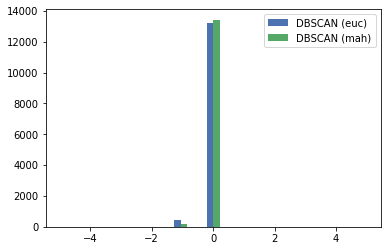

In [16]:
plt.style.use('seaborn-deep')

bins = np.linspace(-5, 5, 20)
plt.hist([clustering.labels_, clustering_mah.labels_], bins, label=['DBSCAN (euc)', 'DBSCAN (mah)'])
plt.legend(loc='upper right')
plt.show()

In [17]:
np.unique(clustering.labels_),len(clustering.labels_[np.where( clustering.labels_ <0 )])

(array([-1,  0], dtype=int64), 415)

In [18]:
np.unique(clustering_mah.labels_),len(clustering_mah.labels_[np.where( clustering_mah.labels_ <0 )])

(array([-1,  0], dtype=int64), 206)

### Validação de  Anomalias
Análise comparativa entre os outliers identificados pela clusterização com os resultados listados pela metalurgia

In [17]:
df_cls=df1_s.copy()

In [18]:
df_cls.loc[:,'cluster_mah']=clustering_mah.labels_
df_cls.loc[:,'cluster_euc']=clustering.labels_

In [19]:
# intervalos de obstrucoes identificados pela metalurgia

filename = r'./data/obstrucao_metalurgia_2019_01_02.csv' # labeling metalurgia
intervals = pd.read_csv(filename,sep=';')

window_size=300 # segundos
clog_intervals = []

for index, row in intervals.iterrows():
    
    istart=pd.to_datetime(row['obstrucao_i'],format='%d/%m/%Y %H:%M')
    iend=pd.to_datetime(row['obstrucao_f'],format='%d/%m/%Y %H:%M')    
    istart_id=int(pd.to_timedelta(pd.Series(istart)).dt.total_seconds().astype(int)//window_size)
    iend_id=int(pd.to_timedelta(pd.Series(iend)).dt.total_seconds().astype(int)//window_size)
    clog_intervals += (list(range(istart_id,iend_id+1,1)))         

In [22]:
# Filtro - Intervalos identificados pela metalurgia identificados com desvio padrao 0
# Serão eliminados da lista de intervalos para proporcionar 100% de match com as features extraidas na fase anterior
# do pipeline (onde se elimina desvio padrão próximos de zero)

std0=[5170654,
 5170657,
 5170658,
 5170659,
 5170660,
 5170661,
 5170662,
 5170663,
 5170664,
 5170665,
 5170666,
 5170667,
 5170668,
 5170669,
 5170670]


In [23]:
df_cls.loc[:,'cluster_metalurgia']=0 # vizualização das observacoes da metalurgia.
df_cls.loc[list(set(clog_intervals)-set(std0)),'cluster_metalurgia']=1

In [24]:
df_cls.loc[list(set(clog_intervals)-set(std0)),['cluster_mah','cluster_euc']].sort_index().to_csv('./data/comparativos.csv')

### Vizualização dos Clusters em espaço dimensional reduzido

In [19]:
df_umap=pd.DataFrame()
df_umap['umap-one']=umap_results[:,0]
df_umap['umap-two']=umap_results[:,1]
df_umap['clusters_euc']=clustering.labels_
df_umap['clusters_mah']=clustering_mah.labels_

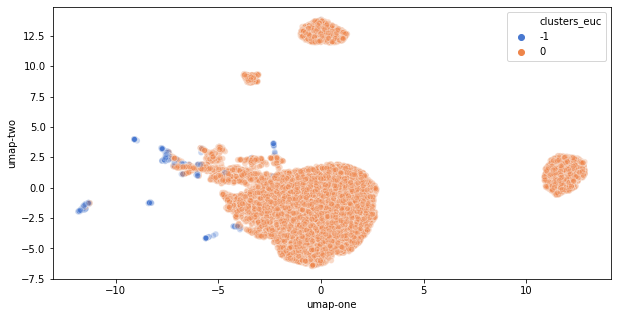

In [20]:
#Visualização Seaborn
plt.figure(figsize=(10,5))
void=sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="clusters_euc",
    palette=sns.color_palette("muted", len(np.unique(clustering.labels_))),
    data=df_umap,
    legend="full",
    alpha=0.3
)

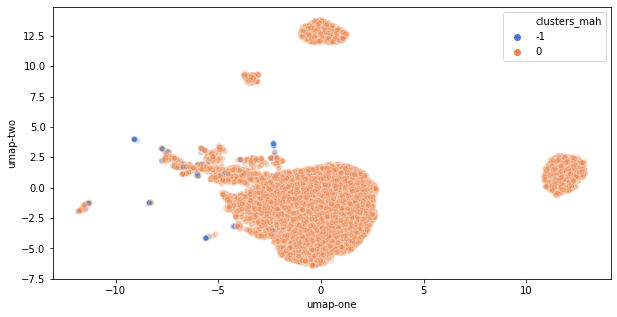

In [21]:
#Visualização Seaborn
plt.figure(figsize=(10,5))
void=sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="clusters_mah",
    palette=sns.color_palette("muted", len(np.unique(clustering_mah.labels_))),
    data=df_umap,
    legend="full",
    alpha=0.3
)

In [25]:
fig = go.Figure(data=go.Scatter(
    x = umap_results[:,0],
    y = umap_results[:,1],
    opacity=0.6,
    mode='markers',
    marker=dict(color=clustering.labels_,
                size=5)
    ,text = list(zip(df1_s.index,clustering.labels_))
))
fig.show()

In [26]:
fig = go.Figure(data=go.Scatter(
    x = umap_results[:,0],
    y = umap_results[:,1],
    opacity=0.6,
    mode='markers',
    marker=dict(color=clustering_mah.labels_,
                size=5)
    ,text = list(zip(df1_s.index,clustering_mah.labels_))
))
fig.show()

In [27]:
cl_e=(clustering.labels_== -1)
cl_mah=clustering_mah.labels_== -1

In [28]:
# Total de Anomalias - Distância euclidiana
df1_s.loc[cl_e].shape

(415, 21)

In [29]:
# Total de Anomalias - Distância de Mahalanobis
df1_s.loc[cl_mah].shape

(206, 21)

In [30]:
# Elementos adicionais identificados com distância de Mahalanobis não presentes 
# no cluster gerado com distância euclidiana
df1_s.loc[cl_mah&(~cl_e)].shape

(38, 21)

In [31]:
# Elementos adicionais identificados com distância de euclidiana não presentes 
# no cluster gerado com distância de mahalanobis
df1_s.loc[cl_e&(~cl_mah)].shape

(247, 21)

In [32]:
umap = UMAP(n_components=2,random_state=74)
umap_results2 = umap.fit_transform(df1_s[cl_mah])

In [33]:
#clustering2 = DBSCAN(eps=0.5, min_samples=5,n_jobs=-1).fit(umap_results2)

param_grid = {
    'eps':np.arange(0.1, 1.8, 0.1),
    'min_samples':range(3,6,1),
    'n_jobs':[-1]
}

best_score=float(-1.0)
max_clusters=15

for g in ParameterGrid(param_grid):
    ca = DBSCAN( **g )
    ca.fit(umap_results2)
    nclusrers = np.unique(ca.labels_).size
    s_score = sc(umap_results2,ca.labels_)
    print (g,s_score,nclusrers)
    if (s_score > best_score) & (nclusrers<=max_clusters):
        best_score=s_score
        best_grid=g

print ("Best Score: %0.5f" % best_score)
print ("Grid:", best_grid)

clustering2=DBSCAN(**best_grid).fit(umap_results2)

{'eps': 0.1, 'min_samples': 3, 'n_jobs': -1} -0.3504344 20
{'eps': 0.1, 'min_samples': 4, 'n_jobs': -1} -0.35985896 4
{'eps': 0.1, 'min_samples': 5, 'n_jobs': -1} 0.21618749 2
{'eps': 0.2, 'min_samples': 3, 'n_jobs': -1} 0.47740483 23
{'eps': 0.2, 'min_samples': 4, 'n_jobs': -1} 0.35785145 21
{'eps': 0.2, 'min_samples': 5, 'n_jobs': -1} 0.098407835 19
{'eps': 0.30000000000000004, 'min_samples': 3, 'n_jobs': -1} 0.6994026 18
{'eps': 0.30000000000000004, 'min_samples': 4, 'n_jobs': -1} 0.69833475 19
{'eps': 0.30000000000000004, 'min_samples': 5, 'n_jobs': -1} 0.6817913 18
{'eps': 0.4, 'min_samples': 3, 'n_jobs': -1} 0.64563996 15
{'eps': 0.4, 'min_samples': 4, 'n_jobs': -1} 0.6384345 14
{'eps': 0.4, 'min_samples': 5, 'n_jobs': -1} 0.681892 14
{'eps': 0.5, 'min_samples': 3, 'n_jobs': -1} 0.4792976 11
{'eps': 0.5, 'min_samples': 4, 'n_jobs': -1} 0.4792976 11
{'eps': 0.5, 'min_samples': 5, 'n_jobs': -1} 0.5771304 12
{'eps': 0.6, 'min_samples': 3, 'n_jobs': -1} 0.5834677 8
{'eps': 0.6, 'min_

In [34]:
pd.unique(clustering2.labels_).size

5

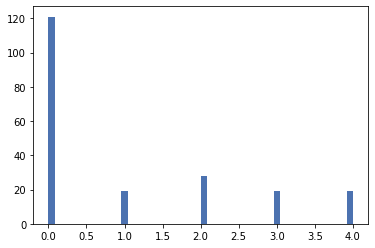

In [35]:
void=plt.hist(clustering2.labels_,bins=50)

In [36]:
df_umap2=pd.DataFrame()
df_umap2['umap-one']=umap_results2[:,0]
df_umap2['umap-two']=umap_results2[:,1]
df_umap2['clusters']=clustering2.labels_

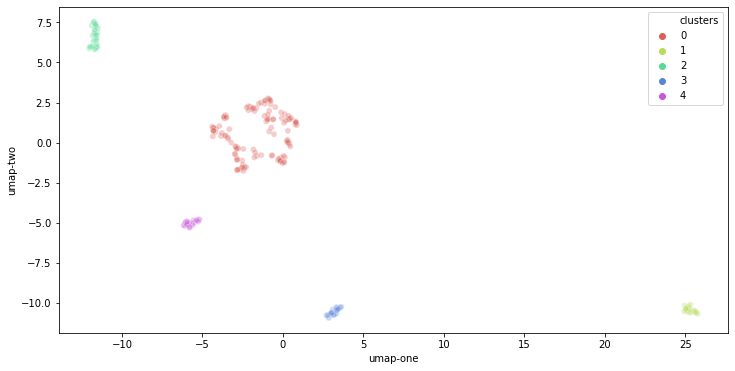

In [37]:
#Visualização Seaborn
plt.figure(figsize=(12,6))
void=sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="clusters",
    palette=sns.color_palette("hls", np.unique(clustering2.labels_).size),
    data=df_umap2,
    legend="full",
    alpha=0.3
)

In [38]:
umap = UMAP(n_components=2,random_state=74)
umap_results2 = umap.fit_transform(df1_s[cl_mah])

In [39]:
fig = go.Figure(data=go.Scatter(
    x = umap_results2[:,0],
    y = umap_results2[:,1],
    opacity=0.8,
    mode='markers',
    marker=dict(color=clustering2.labels_,
                size=5)
    ,text = list(zip(df1_s[cl_mah].index,clustering2.labels_))
))
fig.show()

In [40]:
clv4=pd.DataFrame(index=df1_s[cl_mah].index,columns=['clusters'])
clv4['clusters']=clustering2.labels_
clv4.to_csv('./data/clusters_Strand4_new.csv')

#### Conclusões Preliminares e Próximos Passos

Os resultados, ainda que preliminares, se demonstraram promissores.

As amostras geradas foram avaliadas e representam cenários anômalos quando comparados com um regime padrão de operação. Como próximos passos será gerado um script para impressão dos intervalos de processo e respectivos gráficos na linha do tempo subdivididos pelos 11 clusters identificados.

O relatório será enviado para a metalurgia para que seja confrontado com as informações presentes nos sistemas de qualidade, tendo por objetivo confirmar a qualidade dos labels gerados.